In [1]:
import os
import xarray as xr
import numpy as np
from pyevtk.hl import gridToVTK

from scipy.ndimage import gaussian_filter

from scripts import stratal as strat
from scripts import mapOutputs2D as mout

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline


## Running the simulation

You will need to do the following in a terminal:

```bash
mpirun -np X python3 runModel.py -i input-strati.yml 
```

where X is the number of processors to use (for example 5).


# Analyse the surface evolution

You can visualise the outputs of your simulations directly in Paraview. Below we also show how this could be extracted as netcdf grids and analysed in Python.


To do so, we will be using the `mapOutputs` Python class (available in the `scripts` folder) to first extract the outputs, remap the unstructured variables on a structured mesh. The class is also performing additional calculations on the dataset to extract individual catchments based on flow accumulation and elevation.

The interpolated model's variables are then exported as `netCDF` files, and each of them contains the following (if available from the simulation):

+ elevation `elevation` (m)
+ cumulative erosion/deposition `erodep` (m)
+ erosion/deposition rate `erodep_rate` (m/yr)
+ water flux discharge (accounting for lakes) `fillDischarge`(m3/yr)
+ sediment flux in rivers `sedimentLoad` (m3/yr)
+ main basin ids `basinID` (integer)
+ rainfall `precipitation` (m/yr)
+ tectonic `uplift` (m/yr)
+ cumulative flexural isostasy `flex` (m)

In [15]:
# Define output folder name for the simulation
out_path = 'results/'

if not os.path.exists(out_path):
    os.makedirs(out_path)

def getOutputs(finput,ncout,maxstp,res):

    grid = mout.mapOutputs(path='./', filename=finput, step=0, 
                        uplift=False, flex=True, model="utm")
    grid.buildUTMmesh(res=res, nghb=4, smth=1.)
    grid.exportNetCDF(ncfile = ncout+str(0)+'.nc')
    for k in range(0, maxstp+1):
        if k>0:
            grid.getData(k)
        grid.buildUTMmesh(res=res, nghb=4, smth=0.)
        grid.exportNetCDF(ncfile = ncout+str(k)+'.nc')

    return

getOutputs('input-strati.yml',os.path.join(out_path, "stp"),25,1000)

We can visualise a specific output 

In [16]:
step5 = xr.open_dataset("results/stp5.nc")
step10 = xr.open_dataset("results/stp10.nc")
step15 = xr.open_dataset("results/stp15.nc")
step25 = xr.open_dataset("results/stp25.nc")

In [6]:
step20

<xarray.Dataset> Size: 1MB
Dimensions:        (y: 101, x: 201)
Coordinates:
  * y              (y) float64 808B 0.0 1e+03 2e+03 ... 9.8e+04 9.9e+04 1e+05
  * x              (x) float64 2kB 0.0 1e+03 2e+03 ... 1.98e+05 1.99e+05 2e+05
Data variables:
    elevation      (y, x) float64 162kB ...
    erodep_rate    (y, x) float64 162kB ...
    erodep         (y, x) float64 162kB ...
    precipitation  (y, x) float64 162kB ...
    fillDischarge  (y, x) float64 162kB ...
    flowDischarge  (y, x) float64 162kB ...
    sedimentLoad   (y, x) float64 162kB ...
    flex           (y, x) float32 81kB ...
    basinID        (y, x) int32 81kB ...
Attributes:
    description:  gospl outputs
    history:      Created Wed Jul 10 09:19:05 2024

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_91882/3487264922.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


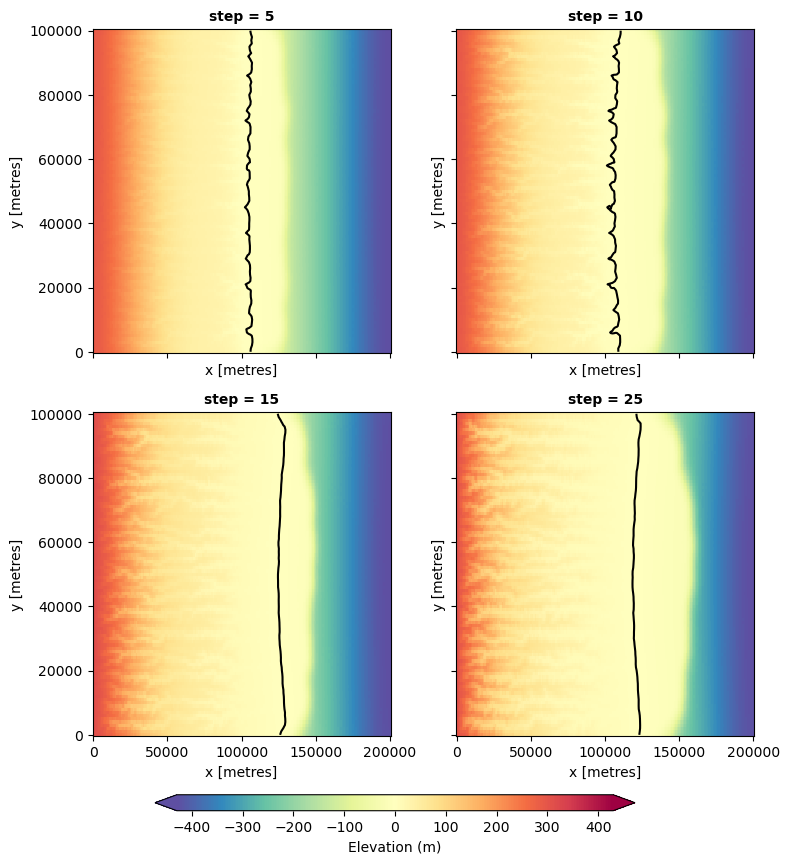

In [17]:
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
step5.elevation.plot(ax=axs[0,0], add_labels=False, add_colorbar=False, cmap='Spectral_r')
step5.elevation.plot.contour(ax=axs[0,0], levels=[0], colors=['k'])
step10.elevation.plot(ax=axs[0,1], add_labels=False, add_colorbar=False, cmap='Spectral_r')
step10.elevation.plot.contour(ax=axs[0,1], levels=[0], colors=['k'])
step15.elevation.plot(ax=axs[1,0], add_labels=False, add_colorbar=False, cmap='Spectral_r')
step15.elevation.plot.contour(ax=axs[1,0], levels=[0], colors=['k'])
im = step25.elevation.plot(ax=axs[1,1], add_labels=False, add_colorbar=False, cmap='Spectral_r')
step25.elevation.plot.contour(ax=axs[1,1], levels=[0], colors=['k'])

axs[0,0].set_title('step = 5', fontsize=10, fontweight="bold")
axs[0,1].set_title('step = 10', fontsize=10, fontweight="bold")
axs[1,0].set_title('step = 15', fontsize=10, fontweight="bold")
axs[1,1].set_title('step = 25', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.02, 0.6, 0.02]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Elevation (m)')

plt.tight_layout()
plt.show()

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_91882/3142651173.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


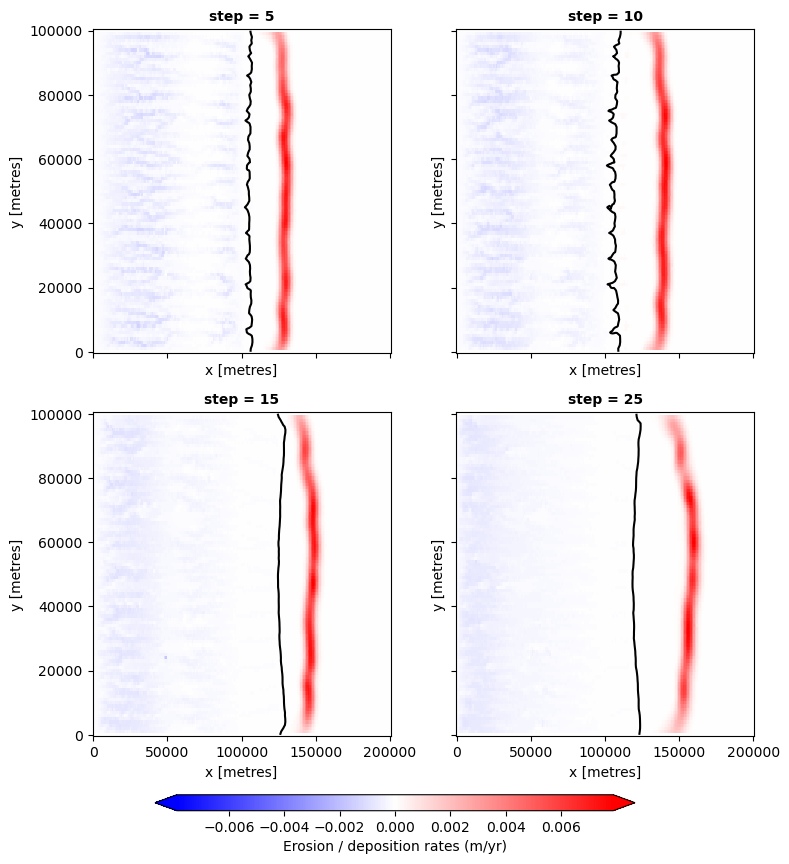

In [20]:
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
step5.erodep_rate.plot(ax=axs[0,0], add_labels=False, add_colorbar=False, cmap='bwr')
step5.elevation.plot.contour(ax=axs[0,0], levels=[0], colors=['k'])
step10.erodep_rate.plot(ax=axs[0,1], add_labels=False, add_colorbar=False, cmap='bwr')
step10.elevation.plot.contour(ax=axs[0,1], levels=[0], colors=['k'])
step15.erodep_rate.plot(ax=axs[1,0], add_labels=False, add_colorbar=False, cmap='bwr')
step15.elevation.plot.contour(ax=axs[1,0], levels=[0], colors=['k'])
im = step25.erodep_rate.plot(ax=axs[1,1], add_labels=False, add_colorbar=False, cmap='bwr')
step25.elevation.plot.contour(ax=axs[1,1], levels=[0], colors=['k'])

axs[0,0].set_title('step = 5', fontsize=10, fontweight="bold")
axs[0,1].set_title('step = 10', fontsize=10, fontweight="bold")
axs[1,0].set_title('step = 15', fontsize=10, fontweight="bold")
axs[1,1].set_title('step = 25', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.02, 0.6, 0.02]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Erosion / deposition rates (m/yr)')

plt.tight_layout()
plt.show()

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_91882/4290905728.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


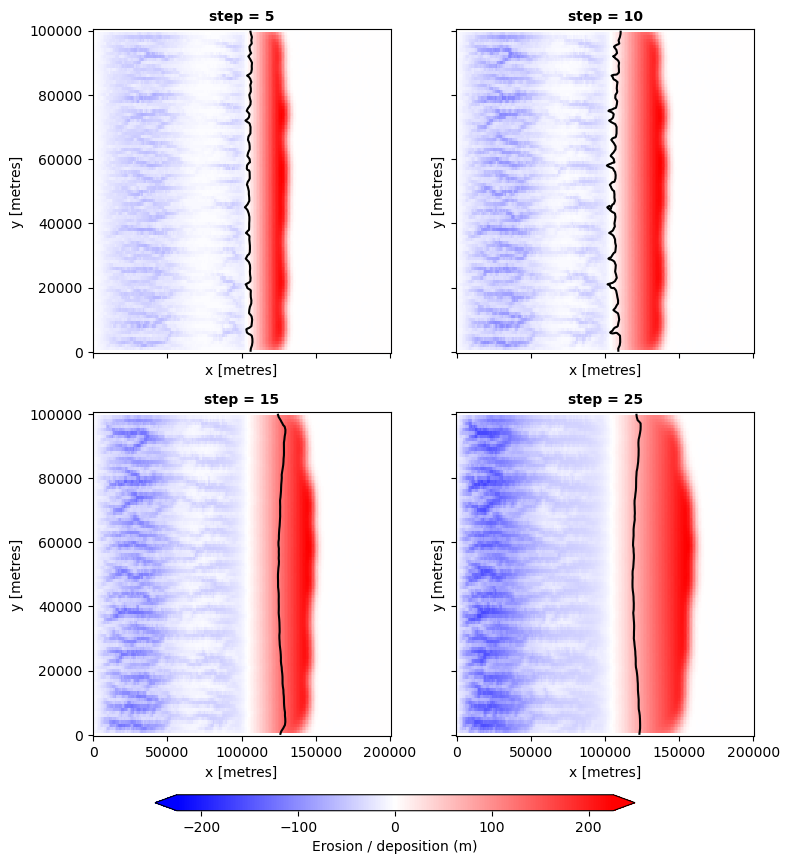

In [22]:
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
step5.erodep.plot(ax=axs[0,0], add_labels=False, add_colorbar=False, cmap='bwr')
step5.elevation.plot.contour(ax=axs[0,0], levels=[0], colors=['k'])
step10.erodep.plot(ax=axs[0,1], add_labels=False, add_colorbar=False, cmap='bwr')
step10.elevation.plot.contour(ax=axs[0,1], levels=[0], colors=['k'])
step15.erodep.plot(ax=axs[1,0], add_labels=False, add_colorbar=False, cmap='bwr')
step15.elevation.plot.contour(ax=axs[1,0], levels=[0], colors=['k'])
im = step25.erodep.plot(ax=axs[1,1], add_labels=False, add_colorbar=False, cmap='bwr')
step25.elevation.plot.contour(ax=axs[1,1], levels=[0], colors=['k'])

axs[0,0].set_title('step = 5', fontsize=10, fontweight="bold")
axs[0,1].set_title('step = 10', fontsize=10, fontweight="bold")
axs[1,0].set_title('step = 15', fontsize=10, fontweight="bold")
axs[1,1].set_title('step = 25', fontsize=10, fontweight="bold")

cbar_ax = fig.add_axes([0.2, -0.02, 0.6, 0.02]) 
cbar = fig.colorbar(im, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('Erosion / deposition (m)')

plt.tight_layout()
plt.show()

Visualise the simulation profile evolution

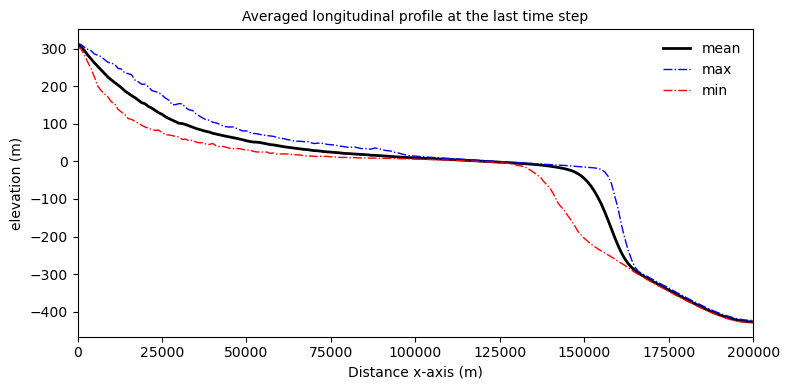

In [48]:
meands = step25.mean(dim='y')
maxds = step25.max(dim='y')
minds = step25.min(dim='y')

plt.figure(figsize=(8,4))
ax = plt.gca()

meands.elevation.plot(lw=2,c='k',label='mean')
maxds.elevation.plot(lw=1,c='b',ls='-.',label='max')
minds.elevation.plot(lw=1,c='r',ls='-.',label='min')

plt.xlabel('Distance x-axis (m)')
plt.ylabel('elevation (m)')
plt.title('Averaged longitudinal profile at the last time step', size=10)
plt.xlim(step25.x.min(),step25.x.max())
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

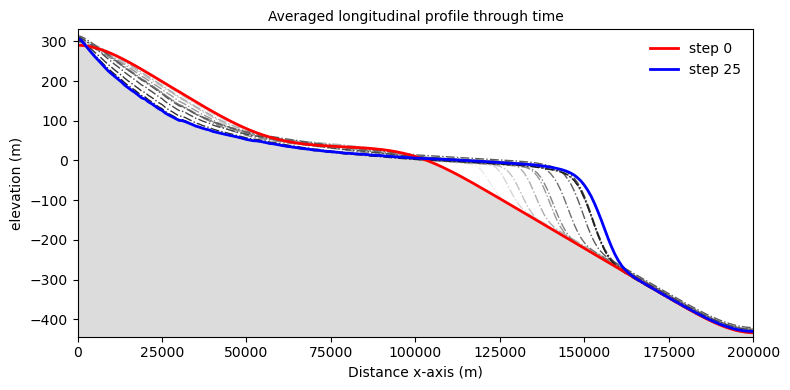

In [47]:
prof_mean = []

for s in range(0,25):
    # Open netcdf data file for the considered time step
    dataset = xr.open_dataset(out_path+'stp'+str(s)+'.nc')
    
    # Get longitudinal profile information
    meands = dataset.mean(dim='y')
    prof_mean.append(meands)


plt.figure(figsize=(8,4))
ax = plt.gca()

cmap = plt.get_cmap('gray_r', len(prof_mean)+1) 
for k in range(0,len(prof_mean),2):
    prof_mean[k].elevation.plot(lw=1, ls='-.', c=cmap(k))


prof_mean[0].elevation.plot(lw=2, c='r', label='step 0')
prof_mean[-1].elevation.plot(lw=2, c='b', label='step 25')

minz = np.minimum(prof_mean[-1].elevation,prof_mean[0].elevation)
ax.fill_between(prof_mean[0].x, -500, minz, facecolor = 'gainsboro')

plt.xlabel('Distance x-axis (m)')
plt.ylabel('elevation (m)')
plt.title('Averaged longitudinal profile through time', size=10)
plt.xlim(dataset.x.min(),dataset.x.max())
plt.ylim(minz.min()-10,330)
plt.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()

# Extract stratigraphy

We will now look at the recorded stratigraphy. The stratigraphic layer are recorded in goSPL as `HDF5` files stored in the output folder as `stratal.XX.pX.h5` where `XX` is the output step and `X` the processor number.


### Stratal record definition

The following information are stored:

+ elevation at time of deposition, considered to be to the current elevation for the top stratigraphic layer `stratZ`.
+ thickness of each stratigrapic layer `stratH` accounting for both erosion & deposition events.
+ porosity of coarse sediment `phiS` in each stratigraphic layer computed at center of each layer.

We will use the `stratal.py` Python class to extract the information above. It requires the following arguments:

+ `path`: the path to the input file
+ `filename`: the name of the input file
+ `layer`: the stratal file you wish to output

In [41]:
# We pick the last step
step = 25

# Load the function and specify the input file
strati = strat.stratal(path='./', filename='input-strati.yml', layer=step, model='utm')

# Read the stratigraphic dataset
strati.readStratalData()

# Interpolate the spherical dataset on a UTM regular grid
# by specifying the desired resolution and interpolation neighbours
strati.buildUTMmesh(res=1000., nghb=3)

Created sedimentary layers: 25
Number of sedimentary layers: 50
Start building regular stratigraphic arrays
Percentage of arrays built : [####################] 100.0% DONE


### Extracting the map for the region

In [42]:
# Smoothing values
sigma=0.3

We now specify the stratigraphic values to extract 

In [43]:
xo = strati.x.min()
xm = strati.x.max()
yo = strati.y.min()
ym = strati.y.max()
lon = np.linspace(xo, xm, strati.nx)
lat = np.linspace(yo, ym, strati.ny)

lons = [0, strati.nx]
lats = [0, strati.ny]
idlat1 = 0
idlat2 = len(lat)
idlon1 = 0
idlon2 = len(lon)

shape = (strati.nx, strati.ny, strati.curLay)
    
# Define the variables shape    
# shape = (idlon2-idlon1,idlat2-idlat1,strati.curLay)

# lon
x = np.empty(shape)
# lat
y = np.empty(shape)
# elevation
z = np.empty(shape)
# elevation at the time of deposition
e = np.empty(shape)
# stratal thickness
h = np.empty(shape)
# layer ID
t = np.empty(shape)
# porosity
ps = np.empty(shape)

# Now let's define the surface elevation
zz = strati.zi[-1, idlat1:idlat2, idlon1:idlon2]
zz = gaussian_filter(zz, sigma)

We use `numba` to speed things up, the function `getVals` will extract the different variables for individual stratigraphic layer.

In [44]:
import numba as nb

@nb.jit(nopython=True)
def getVals(k, idlat1, idlat2, idlon1, idlon2, lon, lat, zz, zi, thu, th, phiSi, topz):
    
    shape = (idlon2-idlon1,idlat2-idlat1)
    lx = np.empty(shape)
    ly = np.empty(shape) 
    lz = np.empty(shape)  
    le = np.empty(shape) 
    lh = np.empty(shape)  
    lps = np.empty(shape)  
    lt = np.empty(shape) 
    
    for j in range(shape[1]):
        for i in range(shape[0]):
            lx[i, j] = lon[i+idlon1]
            ly[i, j] = lat[j+idlat1]  
            if topz is None:
                lz[i, j] = zz[j, i]
            else:
                lz[i, j] = topz[i, j] - thu[j, i]
            le[i, j] = zi[j, i]
            lh[i, j] = th[j, i]
            lps[i, j] = phiSi[j, i]
            lt[i, j] = k
    
    return lx, ly, lz, le, lh, lps, lt

Looping over each layer we extract the information for the desired region:

In [45]:
for k in range(strati.curLay - 1, -1, -1):
    
    if sigma > 0:
        th = gaussian_filter(strati.thi[k, idlat1:idlat2, idlon1:idlon2], sigma)
    th[th < 0] = 0.0
    if k < strati.curLay - 1:
        if sigma > 0:
            thu = gaussian_filter(strati.thi[k + 1, idlat1:idlat2, idlon1:idlon2], sigma)
        thu[thu < 0] = 0.0
    else:
        thu = None
    zi = strati.zi[k, idlat1:idlat2, idlon1:idlon2]
    phiSi = strati.phiSi[k, idlat1:idlat2, idlon1:idlon2]
    
    if k == strati.curLay - 1:
        topz = None
    else:
        topz = z[:, :, k + 1] 
        
    ( x[:, :, k], y[:, :, k], z[:, :, k], 
     e[:, :, k], h[:, :, k], ps[:, :, k], 
     t[:, :, k] 
    ) = getVals(k, idlat1, idlat2, idlon1, idlon2,
                lon, lat, zz, zi, thu, th, phiSi, topz)

We save the dataset as a `vtk` file:

In [46]:
gridToVTK(
            'strati_stp'+str(step),
            x,
            y,
            z,
            pointData={"dep elev": e, "th": h, "layID": t, "phiC": ps,},
        )

'/Users/galois/workspace/test-goSPL/Local-examples/stratigraphic_record/strati_stp25.vts'

This `vtk` file can be visualised in Paraview directly.

## Analysing the stratigraphic mesh

Depositional facies are defined based on the water depth at the time of deposition. Here we define 5 facies and the depth ranges of each facies:

+ Fluvial and deltaic plain: above sea level
+ Shoreface: 0-20 m
+ Distal offshore: 20-50 m
+ Upper slope: 50-75 m
+ Lower slope: >75 m

In [49]:
def build_facies(secElev = None, secTh = None, nz = None, depthIDs = None):
    
    envi = np.zeros((nz, len(depthIDs)+2))
    for i in range(0,nz):
        # get the onlap location
        onlapID = np.where((secTh[:,i]) >= 0.1)[0]
        if(len(onlapID)>0):
            envi[i][0] = np.amin(onlapID)
        
        # get the onlap location
        downlapID = np.where((secTh[:,i]) >= 0.0001)[0]
        if(len(downlapID)>0):
            envi[i][len(depthIDs)+1] = np.amax(downlapID)
            
        for j in range(len(depthIDs)):
            rangeID = np.where((secElev[:,i]) <= depthIDs[j])[0]
            if(len(rangeID)==0):
                envi[i][j+1] = max(envi[i][len(depthIDs)+1],envi[i][j])
            else:
                envi[i][j+1] = np.amin(rangeID)

    return envi

In [61]:
# Specify the location of cross section in X (or Y) direction
loc = int(50)
strat_secDep = np.array((z[:,loc,:]))*-1
strat_secElev = np.array((e[:,loc,:]))
strat_secTh = np.array((h[:,loc,:]))
strat_nz = strati.curLay
 
# Specify the range of water depth for the depositional environments, see the table above
depthID = [0, -30, -100, -200]

# Build an array of depositional environment ID (enviID)
enviID = np.zeros((strat_nz, len(depthID)+2))
enviID = build_facies(secElev = strat_secElev, secTh = strat_secTh, nz = strat_nz, depthIDs = depthID)

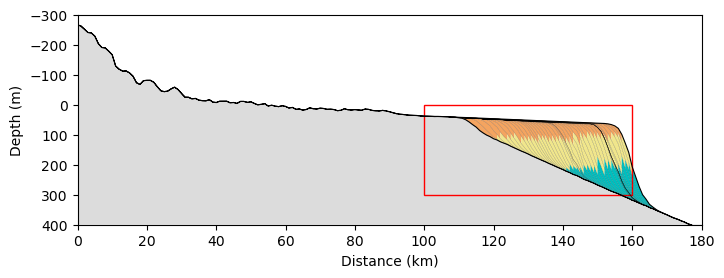

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_91882/1546425565.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


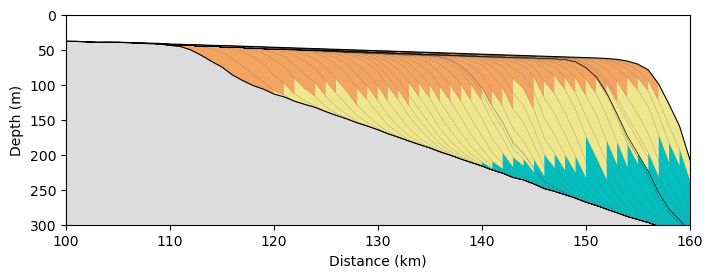

In [99]:
# Plot stratal stacking pattern colored by facies
fig = plt.figure(figsize = (8,3))

ax = fig.add_axes([0.15, 0.23, 0.78, 0.7])
xi00 = np.array(lon)/1000.  # change the unit to be be km
colors = ['limegreen','darkkhaki','sandybrown','khaki','c','teal']
for i in range(0,strat_nz-1,1):
    ax.plot(xi00,strat_secDep[:,i],'-',color='k',linewidth=0.1)
    for j in range(len(depthID)+1):
        ID1=enviID[i][j]
        ID2=enviID[i][j+1]+1
        if (ID1<ID2):
            ax.fill_between(xi00[int(ID1):int(ID2)], strat_secDep[:,i][int(ID1):int(ID2)],strat_secDep[:,i+1][int(ID1):int(ID2)],
                            facecolor=colors[j], linewidth=0)

ax.fill_between(xi00, 400, strat_secDep[:,0], facecolor = 'gainsboro')
ax.plot(xi00,strat_secDep[:,strat_nz-1],'-',color='k',linewidth=0.8)  # top line
ax.plot(xi00,strat_secDep[:,0],'-',color='k',linewidth=0.8)  # bottom line
ax.set_xlim([0, 180])
ax.set_ylim([400, -300])
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')

rect = patches.Rectangle((100, 0), 60, 300, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

plt.show()
# Save the plot
# fig.savefig("Strata_delta_%d_%d.pdf"%(foldername, csloc, timestep), dpi=400)
# plt.close(fig)

fig = plt.figure(figsize = (8,3))

ax = fig.add_axes([0.15, 0.23, 0.78, 0.7])
xi00 = np.array(lon)/1000.  # change the unit to be be km
colors = ['limegreen','darkkhaki','sandybrown','khaki','c','teal']
for i in range(0,strat_nz-1,1):
    ax.plot(xi00,strat_secDep[:,i],'-',color='k',linewidth=0.1)
    for j in range(len(depthID)+1):
        ID1=enviID[i][j]
        ID2=enviID[i][j+1]+1
        if (ID1<ID2):
            ax.fill_between(xi00[int(ID1):int(ID2)], strat_secDep[:,i][int(ID1):int(ID2)],strat_secDep[:,i+1][int(ID1):int(ID2)],
                            facecolor=colors[j], linewidth=0)

ax.fill_between(xi00, 400, strat_secDep[:,0], facecolor = 'gainsboro')
ax.plot(xi00,strat_secDep[:,strat_nz-1],'-',color='k',linewidth=0.8)  # top line
ax.plot(xi00,strat_secDep[:,0],'-',color='k',linewidth=0.8)  # bottom line
ax.set_xlim([100, 160])
ax.set_ylim([300, 0])
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')
plt.tight_layout()
plt.show()

### Plot chronostratigraphic chart

/var/folders/n3/vd5l_ngx2hl52j9g7wgj3dqh0000gn/T/ipykernel_91882/864961647.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


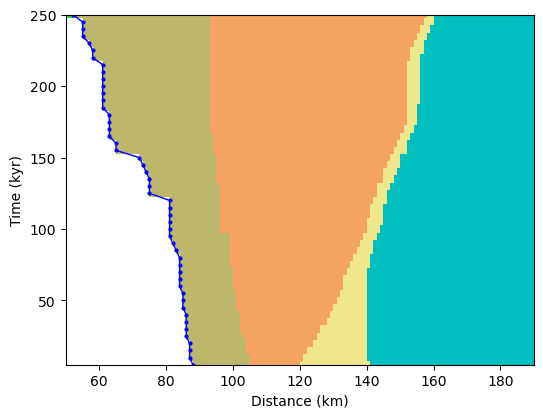

In [111]:
res = 1.  # spatial resolution in km

# Time structure of the model
start_time = 0. 
laytime = 5000. 
nbSec = 2 # (number of sections per display time)
end_time = start_time + laytime * step  * nbSec
layertime = np.linspace(start_time+laytime,end_time,step * nbSec) 

# Extract the shoreline and 3-m isobath trajectories
shoreline = []
isobath_3m = []
for i in range(strat_nz):
    shoreline.append(np.min(np.where(strat_secElev[:,i]<=0)))
    isobath_3m.append(np.min(np.where(strat_secElev[:,i]<=-3)))

# Plot chronostrat chart
fig = plt.figure(figsize = (6,5))
plt.rc("font", size=10)

ax = fig.add_axes([0.15, 0.23, 0.78, 0.7]) 
colors = ['white','limegreen','darkkhaki','sandybrown','khaki','c','teal']
for i in range(len(enviID.T)):
    ax.barh(layertime/1e3, (enviID.T[i]-enviID.T[i-1])*res, align='center', height=laytime/1.e3, left=enviID.T[i-1]*res, color=colors[i])
ax.plot(np.array(shoreline)*res, layertime/1e3, '-o', markersize=2, linewidth=1, color='blue')
ax.set_xlim([50, 190])
ax.set_ylim([5,end_time/1e3])
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Time (kyr)')
plt.tight_layout()
plt.show()
# fig.savefig("figures/%s/WheeDiag_delta_%d.pdf"%(foldername, loc), dpi=400)
# plt.close(fig)